# Bayesian Regression

This notebook should be a cleaner, more updated version of Bayesian_reg_2. Here we will use the priors that were computed from the nested ridge regression methodology, and we will run the regression on 20k shifts. We will run it for three values of sigma - 2, 3, and 4 since these seem to be the most reasonable. 

**Note** - at this time we have not yet addressed the issue of rookie contracts, so players like Luka Doncic and Donovan Mitchell have inaccurate priors. 

In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az

data = pd.read_csv("../data/shifts_data_final_2018_19.csv")
data.drop(data.columns[0], axis = 1, inplace = True)
data.head()

,point_diff_per_100,home_team,away_team,0,1,2,3,4,5,6,...,519,520,521,522,523,524,525,526,527,528
0,-36.458333,Celtics,Nuggets,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,39.062500,Celtics,Nuggets,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-72.337963,Celtics,Nuggets,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-36.168981,Celtics,Nuggets,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,38.296569,Celtics,Nuggets,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Note - the priors are too small. Scale them up to range from like -10 to 10

So far with standard dev of 4, the results are worse with these priors compared to the old priors we used before. We see random players with very high +/-

#### Note - line 17 in the code chunk below also rescales rookie priors to be 75% of veteran priors

In [2]:
priors_df = pd.read_csv("../data/Ridge_Priors+SE_2017.csv")
priors_df.drop(priors_df.columns[0], axis = 1, inplace = True)
priors_df.columns = ['Team', 'mu', 'sd', 'name', 'coefs', 'idx', 'player_id', 'finalpriors', 'finalse']
priors_df.head()
priors_df.sort_values(by = ['idx'], inplace = True)

rookie_priors_df = pd.read_csv("../data/priors_rookies.csv")
rookie_priors_df.columns = ["idx", "mu", "sd", "name", "type"]
rookie_priors_df

priors_range = max(priors_df.finalpriors) - min(priors_df.finalpriors)
priors_range

rookie_priors_range = max(rookie_priors_df.mu) - min(rookie_priors_df.mu)
rookie_priors_range

factor = priors_range / rookie_priors_range * 0.75 # we will rescale rookies to have 75% of the range of vets since they shouldn't be equivalent to someone like Lebron
rookie_priors_df.mu *= factor
rookie_priors_df.mu -= np.mean(rookie_priors_df.mu) # center rookie means

rookie_priors_df.sd = max(priors_df.finalse) # set the se for all rookies to be the max se found among veterans since rookies should be more variable intuitively
rookie_priors_df

# max(rookie_priors_df.mu) - min(rookie_priors_df.mu)
# factor = 15 / priors_range

# priors_df.finalpriors *= factor
# priors_df.sort_values(by = ['finalpriors']).tail(20)

# priors_df.finalpriors -= np.mean(priors_df.finalpriors)

# priors_df.sort_values(by = ['finalpriors']).tail(20)

,idx,mu,sd,name,type
0,1,2.249577,0.761081,Jayson Tatum,Rookie
1,2,1.237387,0.761081,Jaylen Brown,Rookie
2,3,-0.164070,0.761081,Terry Rozier,Rookie
3,14,-0.889821,0.761081,OG Anunoby,Rookie
4,16,-0.503590,0.761081,Delon Wright,Rookie
...,...,...,...,...,...
97,494,-0.510240,0.761081,Dario Saric,Rookie
98,504,-0.916798,0.761081,Aaron Holiday,Rookie
99,507,-0.622432,0.761081,Lonnie Walker IV,Rookie
100,514,1.625617,0.761081,Brandon Ingram,Rookie


In [3]:
# Now we need to go through priors_df and drop any rows that are for players with rookie contracts
drop_lst = []

for i in range(len(priors_df)):
    cur_idx = priors_df.iloc[i]['idx']
    if cur_idx in np.array(rookie_priors_df['idx']):
        drop_lst.append(i) # add this index to the list of indexes to be dropped
        
# priors_df.reset_index(drop = True, inplace = True)
priors_df.drop(drop_lst, inplace = True)
        
priors_df

,Team,mu,sd,name,coefs,idx,player_id,finalpriors,finalse
70,Boston Celtics,1.666667,5,Marcus Morris,-4.003747,0,202694,-0.269767,0.259020
68,Boston Celtics,1.881800,5,Jayson Tatum,3.790331,1,1628369,-0.158154,0.253661
67,Boston Celtics,1.652160,5,Jaylen Brown,-8.338793,2,1627759,-0.277293,0.259416
73,Boston Celtics,0.662840,5,Terry Rozier,-2.256052,3,1626179,-0.790558,0.295269
308,Chicago Bulls,4.596167,5,Robin Lopez,3.294456,4,201577,1.249145,0.414105
...,...,...,...,...,...,...,...,...,...
179,Miami Heat,4.651333,5,James Johnson,-6.849357,509,201949,1.278399,0.251177
171,Charlotte Hornets,0.900000,5,Michael Carter-Williams,-4.064299,510,203487,-0.667793,0.239569
320,Phoenix Suns,1.050977,5,T.J. Warren,5.711320,513,203933,-0.590305,0.455433
214,Los Angeles Lakers,1.839800,5,Brandon Ingram,1.426551,514,1627742,-0.180359,0.214220


In [4]:
# Note - priors_df is missing any players with no contract data due to name inconsistencies. We will fill them in with zero means here
prior_means = np.zeros(529)

for i in range(len(prior_means)):
    if i in np.array(priors_df['idx']):
        prior_means[i] = priors_df.loc[priors_df['idx'] == i]['finalpriors'].iloc[0]
    elif i in np.array(rookie_priors_df['idx']):
        prior_means[i] = rookie_priors_df.loc[rookie_priors_df['idx'] == i]['mu'].iloc[0]

In [5]:
prior_sd = np.full(529, np.mean(priors_df.finalse)) # initialize all standard errors to the mean, then we'll edit below

for i in range(len(prior_sd)):
    if i in np.array(priors_df['idx']):
        prior_sd[i] = priors_df.loc[priors_df['idx'] == i]['finalse'].iloc[0]
    elif i in np.array(rookie_priors_df['idx']):
        prior_sd[i] = rookie_priors_df.loc[rookie_priors_df['idx'] == i]['sd'].iloc[0]



# prior_sd4 = np.full(529, 4)
# prior_sd3 = np.full(529, 3)
# prior_sd2 = np.full(529, 2)

In [6]:
# store home and away teams for potential use later when we incorporate team ratings
home_teams = data['home_team']
away_teams = data['away_team']
# now drop these columns from the main training dataframe
data.drop(['home_team', 'away_team'], axis = 1, inplace = True)
data.head()

,point_diff_per_100,0,1,2,3,4,5,6,7,8,...,519,520,521,522,523,524,525,526,527,528
0,-36.458333,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,39.062500,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-72.337963,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-36.168981,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,38.296569,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# need to rename columns now since numbers confuse pymc3
new_cols = []
for i in range(np.shape(data)[1]):
    if i == 0:
        new_cols.append("point_diff")
    else:
        new_cols.append("p" + str(i-1))

# x_df = data.iloc[:20000,]
x_df = data
x_df.columns = new_cols
x_df

,point_diff,p0,p1,p2,p3,p4,p5,p6,p7,p8,...,p519,p520,p521,p522,p523,p524,p525,p526,p527,p528
0,-36.458333,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,39.062500,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-72.337963,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-36.168981,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,38.296569,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33885,-52.083333,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33886,38.868159,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33887,60.562016,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33888,-72.337963,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Below we fit the Bayesian model. ONLY run this cell if we do not have a saved trace. If we have a saved trace, proceed further down and execute the cell to load a saved trace.

In [60]:
x = np.array(x_df.iloc[:,1:])
y = np.array(x_df.iloc[:,0])

x_shape = np.shape(x)[1]
    
with pm.Model() as model:
    # priors
    sigma = pm.HalfCauchy("sigma", beta=10) # arbitrarily defined
    intercept = pm.Normal("Intercept", 0, sigma=20) # arbitrarily defined
    x_prior_means = prior_means # defined above
    x_prior_sigmas = prior_sd * 5 # defined above
#     x_prior_means = np.zeros(x_shape) # just testing with mean zero to compare to ridge
    x_coeff = pm.Normal("x", mu = x_prior_means, sigma=x_prior_sigmas, shape = x_shape) # original method - no list comprehension

    likelihood = pm.Normal("y", mu=intercept + x_coeff.dot(x.T), sigma=sigma, observed=y) # original method - no list comprehension
    
    trace = pm.sample(1000, tune = 1000, cores = 1)
    
    

/Users/reedpeterson/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [x, Intercept, sigma]


/Users/reedpeterson/opt/anaconda3/lib/python3.7/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1660 seconds.


## Below we save the trace

In [78]:
with model:
    path = pm.save_trace(trace, directory = "main_model_trace")

OSError: Cautiously refusing to overwrite the already existing main_model_trace! Please supply a different directory, or set `overwrite=True`

In [61]:
with model:
    results_df = az.summary(trace)

## Below we load the saved trace

In [27]:
x = np.array(x_df.iloc[:,1:])
y = np.array(x_df.iloc[:,0])

x_shape = np.shape(x)[1]
    
with pm.Model() as model:
    # priors
    sigma = pm.HalfCauchy("sigma", beta=10) # arbitrarily defined
    intercept = pm.Normal("Intercept", 0, sigma=20) # arbitrarily defined
    x_prior_means = prior_means # defined above
    x_prior_sigmas = prior_sd # defined above
#     x_prior_means = np.zeros(x_shape) # just testing with mean zero to compare to ridge
    x_coeff = pm.Normal("x", mu = x_prior_means, sigma=x_prior_sigmas, shape = x_shape) # original method - no list comprehension

    likelihood = pm.Normal("y", mu=intercept + x_coeff.dot(x.T), sigma=sigma, observed=y) # original method - no list comprehension
    
    loaded_trace = pm.load_trace("main_model_trace")
    
    results_df = az.summary(loaded_trace)

In [10]:
# import the player map dictionary to go between index, player_id, and name
player_index_map = pd.read_csv("../data/player_index_map.csv")

In [87]:
player_index_map.loc[player_index_map.player_name == "Kyrie Irving"]
player_index_map.loc[player_index_map.index == 322]

,Unnamed: 0,player_id,index,player_name
322,322,203095.0,322,Evan Fournier


In [86]:
print((results_df.loc[results_df['mean'] > 2]).sort_values(by=['mean']))

# results_df.iloc[406]

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
x[60]    2.011  1.124  -0.038    4.257      0.018    0.015    4001.0   
x[170]   2.047  1.395  -0.704    4.575      0.024    0.021    3427.0   
x[4]     2.108  1.732  -1.005    5.530      0.030    0.030    3399.0   
x[503]   2.118  1.345  -0.443    4.499      0.023    0.024    3500.0   
x[261]   2.118  2.118  -1.562    6.152      0.034    0.036    3821.0   
x[256]   2.132  2.343  -2.338    6.346      0.037    0.041    4048.0   
x[100]   2.155  1.651  -1.165    5.070      0.029    0.027    3234.0   
x[449]   2.156  1.741  -0.827    5.494      0.029    0.028    3558.0   
x[13]    2.156  1.849  -1.312    5.561      0.031    0.032    3528.0   
x[515]   2.258  2.808  -2.886    7.557      0.047    0.053    3507.0   
x[380]   2.292  1.626  -0.570    5.468      0.026    0.024    3881.0   
x[70]    2.308  1.437  -0.550    4.754      0.023    0.021    3926.0   
x[51]    2.340  1.721  -0.776    5.538      0.028    0.025    37

## Results from using the Ridge-derived priors for mean and sd for each player, running Bayesian Regression on full season

When we use nested ridge regression to derive prior means and standard deviations for each player, we see the following results for the Bayesian regression model: 

* Steph Curry
* Paul Millsap
* LeBron James
* James Harden
* Gordon Hayward (this one is bizarre - Hayward was not good in 2018-19 or 2017-18 so his prior should not be high and his 2018/19 data should not boost him)
* Al Horford
* Damian Lillard
* Mike Conley
* DeMar DeRozan
* Carmelo Anthony (another bizarre one - Melo was not good)
* Markelle Fultz (another bad one - I think we're starting to see that priors are being weighed too heavily due to small standard errors)
* KD
* CP3
* Bradley Beal
* AD
* Andre Drummond
* Brook Lopez
* Giannis

### Now - results after we scale up the standard deviations by a factor of 3

* Curry
* Millsap
* Harden
* Dame
* LeBron
* Hayward
* Al Horford
* Giannis
* Rudy Gobert
* Brook Lopez
* Bradley Beal
* Steven Adams
* Luka Doncic
* AD
* Andre Drummond
* PG
* Mike Conley
* CP3
* KD
* Danilo Galinari

### When we scale up standard deviations by factor of 5, we see essentially the same results as above

## The following cell shows how to get the distribution for a specific player

In this case we get the distribution for Steph Curry (index 317)

/Users/reedpeterson/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


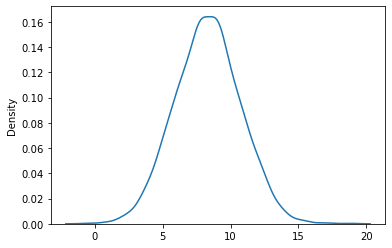

In [88]:
import seaborn as sns

with model:
#     az.plot_trace(trace3)
#     print(np.shape(trace3['x']))
#     print(max(trace3['x'][:,317]))
    sns.distplot(trace['x'][:,317], hist = False)

In [ ]:
with model:
    az.plot_trace(trace)

In [103]:
with model:
    tmp = trace.get_values("x")

# np.shape(tmp)
# np.mean(tmp, axis = 0)
tmp_df = pd.DataFrame(tmp)
tmp_df.to_csv(r'../data/bayesian_posterior_samples.csv')

In [95]:
results_df.to_csv(r'../data/bayesian_results_df.csv')